In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchmetrics.functional import accuracy
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchmetrics.functional import accuracy
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
import os
from tqdm import tqdm
import tifffile
import random
import sys
import cv2
import torch.nn as nn
from torchmetrics.classification import JaccardIndex
from torch.nn.parallel import DataParallel
from torchsummary import summary

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_gpus = torch.cuda.device_count()
x= torch.cuda.empty_cache()
device , num_gpus ,x


('cuda', 4, None)

In [3]:
from cad_pe.data import *

In [4]:
data_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Resize((128,128)),
                                     #transforms.Grayscale(num_output_channels = 1),
                                     ])

In [5]:
data_folder = "/data/jliang12/nuislam/CAD_PE_Challenge_Data/np_images"
coco = '/home/akaniyar/ctpa_seg/coco_dataset.json'

In [6]:
import json
with open(coco) as json_file:
    data = json.load(json_file)

In [7]:
my_dataset = cadpedataset(root=data_folder,
                          annotation=data,
                          transforms=data_transform
                          )

len(my_dataset)

21917

In [10]:
i,l = my_dataset[200]

In [11]:
x= l['boxes']

torch.unique(i)

tensor([0.0000e+00, 6.9195e-05, 1.3839e-04,  ..., 8.3117e-01, 8.5040e-01,
        9.2928e-01])

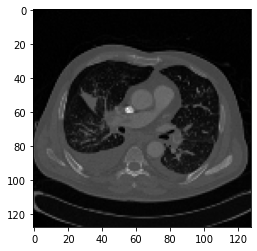

In [12]:
plt.imshow(i.permute(1,2,0),cmap="gray")

[[82.   73.75 87.75 78.5 ]
 [88.   67.5  93.25 71.75]
 [48.5  60.5  49.   60.75]
 [41.   59.   59.   73.  ]]
[0.0000000e+00 6.9194575e-05 1.3838915e-04 ... 8.3116525e-01 8.5040134e-01
 9.2928314e-01]


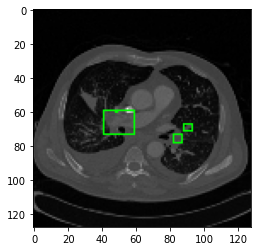

In [13]:
bbox_img = i.numpy().squeeze().copy()
x = l["boxes"]
box = x.numpy()
print(box)
# Convert the image to BGR format and scale the bounding box coordinates
bbox_img_bgr = cv2.cvtColor((bbox_img *255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
# x_scale = 128/ 512
# y_scale = 128/ 512
print(np.unique(bbox_img))
for bbox in box:
    x, y, x_plus_w, y_plus_h = bbox
    x, y, x_plus_w, y_plus_h = int(x), int(y), int(x_plus_w), int(y_plus_h)
    # x = int(x * x_scale)
    # y = int(y * y_scale)
    # x_plus_w = int(x_plus_w * x_scale)
    # y_plus_h = int(y_plus_h * y_scale)
    cv2.rectangle(bbox_img_bgr, (x, y), (x_plus_w, y_plus_h), (0, 255, 0), 1)

# Display the image with bounding boxes
plt.imshow(bbox_img_bgr, cmap="gray")
#plt.axis('off')
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
# import time
# start = time.time()
train, test = train_test_split(my_dataset, test_size=0.10, random_state=42)
# test, val = train_test_split(temp, test_size=0.50, random_state=42)
# print(f"Total time: {(time.time() - start)/60}")
print(len(train), len(test))

450 50


In [15]:
i,l = test[5]


[[82.75 77.25 84.25 78.75]
 [80.25 74.75 82.25 76.  ]
 [84.75 71.5  86.5  73.75]
 [83.5  67.25 85.   69.5 ]
 [81.25 62.5  83.25 67.  ]]
[0.0000000e+00 6.1050065e-05 1.2210013e-04 ... 9.2472529e-01 9.6141636e-01
 9.8772895e-01]


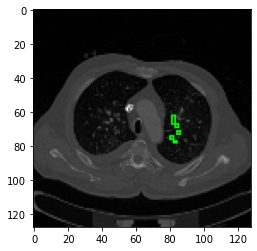

In [16]:
bbox_img = i.numpy().squeeze().copy()
x = l["boxes"]
box = x.numpy()
print(box)
# Convert the image to BGR format and scale the bounding box coordinates
bbox_img_bgr = cv2.cvtColor((bbox_img *255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

print(np.unique(bbox_img))
for bbox in box:
    x, y, x_plus_w, y_plus_h = bbox
    x, y, x_plus_w, y_plus_h = int(x), int(y), int(x_plus_w), int(y_plus_h)
    cv2.rectangle(bbox_img_bgr, (x, y), (x_plus_w, y_plus_h), (0, 255, 0),)

# Display the image with bounding boxes
plt.imshow(bbox_img_bgr, cmap="gray")
#plt.axis('off')
plt.show()

In [17]:
def collate_fn(batch):
    return tuple(zip(*batch))

batch_size = 8
num_workers = 3
train_loader = torch.utils.data.DataLoader(train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_gpus,
                                          collate_fn=collate_fn)

# own DataLoader
test_loader = torch.utils.data.DataLoader(test,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_gpus,
                                         collate_fn=collate_fn)

# own DataLoader
# val_loader = torch.utils.data.DataLoader(val,
#                                           batch_size=batch_size,
#                                           shuffle=True,
#                                           num_workers=num_workers,
#                                         collate_fn=collate_fn)

In [18]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [19]:
from torchmetrics.functional.classification import jaccard_index

In [20]:
i,l = next(iter(train_loader))

In [21]:
print(torch.unique(i[0]))

tensor([0.0000e+00, 6.1050e-05, 1.2210e-04,  ..., 9.6502e-01, 9.9286e-01,
        9.9701e-01])


In [22]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    SMOOTH = 1
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    # thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return iou

In [23]:
from tqdm import tqdm
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights = "DEFAULT")
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model
    


num_classes = 2
model = get_model_instance_segmentation(num_classes)
model = DataParallel(model, device_ids=list(range(num_gpus)), dim=0)
#model = torch.load("/home/akaniyar/Colonoscopy/all_model/CVC_scratch.pth")
model = model.to(device)
model


DataParallel(
  (module): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            

In [68]:
def train(train, model, num_epochs,offset): 
    # move model to the right device
    model.to(device)

    # parameters
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)

    len_dataloader = len(train)
    loss_list = []
    for epoch in tqdm(range(num_epochs)):
        temp_loss=0
        model.train()
        i = 0    
        for imgs, label in train:
            i += 1
            imgs = list(img.to(device) for img in imgs)
            label = [{k:v.to(device) for k, v in t.items()} for t in label]
            #print(imgs ,label)
            # annotations =[{k:[v.to(device) for v in v_list]} for t in annotations for k, v_list in t.items()]
            #annotations = [{key: value.to(device)  if torch.is_tensor(value) else value for key, value in t.items() }for t in annotations]
            # print(label)
            loss_dict = model(imgs, label)
            # print(loss_dict.keys())
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            # print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
            temp_loss+=losses
            
# #         # ******* VALIDATION *********
# #         # evaluate on validation set
# #         model.eval()
# #         with torch.no_grad():
# #             for images, label in val:
# #                 imgs = list(image.to(device) for image in images)
# #                 annotations = [{k: v.to(device) for k, v in t.items()} for t in label]
# #                 output = model(imgs)
# #                 print(output)
# #                 loss = loss_fn(output, label)

# #                 val_iou = IOU(output, label)

# #                 val_loss.append(loss.item())
# #                 avg_iou_val.append(val_iou.item())
# #                 break
                
                
        temp_loss = temp_loss / i
        loss_list.append(temp_loss)
        print(f"Epoch:{epoch+1}|Train Loss:{temp_loss.item():.5f}")
#         logger.info(f"Epoch:{epoch+1}|Train_Loss:{temp_loss:.5f}")
# #         if epoch!=0 and temp_loss < losses[-1]:
#         torch.save(model, f"/scratch/spanchak/colonoscopy/CAPDE_models/CADPE_{epoch+1}.pt")   
            
# 2 classes; Only target class or background

In [110]:
num_classes = 2
num_epochs = 15
train(train=train_loader, model=model, num_epochs=num_epochs, offset = 29)

  7%|▋         | 1/15 [00:42<09:56, 42.63s/it]

Epoch:1|Train Loss:0.04601


 13%|█▎        | 2/15 [01:31<10:00, 46.18s/it]

Epoch:2|Train Loss:0.04241


 20%|██        | 3/15 [02:21<09:35, 47.98s/it]

Epoch:3|Train Loss:0.04662


 27%|██▋       | 4/15 [03:12<09:00, 49.11s/it]

Epoch:4|Train Loss:0.04430


 33%|███▎      | 5/15 [04:03<08:18, 49.90s/it]

Epoch:5|Train Loss:0.04804


 40%|████      | 6/15 [04:55<07:35, 50.59s/it]

Epoch:6|Train Loss:0.03104


 40%|████      | 6/15 [05:01<07:32, 50.25s/it]


KeyboardInterrupt: 

In [144]:
def plot_gt_pred(test_loader, ground_truth_boxes, predicted_boxes):
    # Select 5 random samples from the test loader
    # test_samples = iter(test_loader)
    # images, labels = next(test_samples)
    # images = list(image.to(device) for image in images)
    # annotations = [{k: v.to(device) for k, v in t.items()} for t in labels]
    images = list(image.to(device) for image in test_loader)
    # Extract ground truth and predicted bounding box coordinates for the selected samples
    gt_bboxes = ground_truth_boxes[:]
    print(len(gt_bboxes))
    pred_bboxes = predicted_boxes[:]
    # print(gt_bboxes[0] , pred_bboxes[0])
    # Loop through the selected samples and plot the ground truth and predicted bounding boxes
    for i in range(1):
        img = images[i+1].cpu().numpy().squeeze().copy()
        # print(img)
        for i in gt_bboxes:
            gt_bbox = i 
            # print(gt_bbox)
        # gt_bbox = gt_bboxes
        for j in pred_bboxes:
            pred_bbox = j
        bbox_img_bgr = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
        bbox_img_bgr2 = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
        # Plot ground truth bounding boxes
        for bbox in gt_bbox:
            x, y, x_plus_w, y_plus_h = bbox
            x, y, x_plus_w, y_plus_h = int(x), int(y), int(x_plus_w), int(y_plus_h)
            # print(x, y, x_plus_w, y_plus_h)
            cv2.rectangle(bbox_img_bgr, (x, y), (x_plus_w, y_plus_h), (0, 255, 0), 0)
            
        # Plot predicted bounding boxes
        for bbox in pred_bbox:
            x, y, x_plus_w, y_plus_h = bbox
            x, y, x_plus_w, y_plus_h = int(x), int(y), int(x_plus_w), int(y_plus_h)
            # print(x, y, x_plus_w, y_plus_h)
            cv2.rectangle(bbox_img_bgr, (x, y), (x_plus_w, y_plus_h), (255, 0, 0), 0)
            
            
        # Display the image with ground truth and predicted bounding boxes side by side
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2,1 )
        plt.imshow(bbox_img_bgr, cmap="gray")
        plt.title("Ground Truth")
        plt.axis('off')
        # plt.subplot(1, 2, 2)
        # plt.imshow(bbox_img_bgr2)
        # plt.title("Predicted")
        plt.axis('off')
        plt.savefig("/home/akaniyar/ctpa_seg/cadpe.png")
        plt.show()
        

8


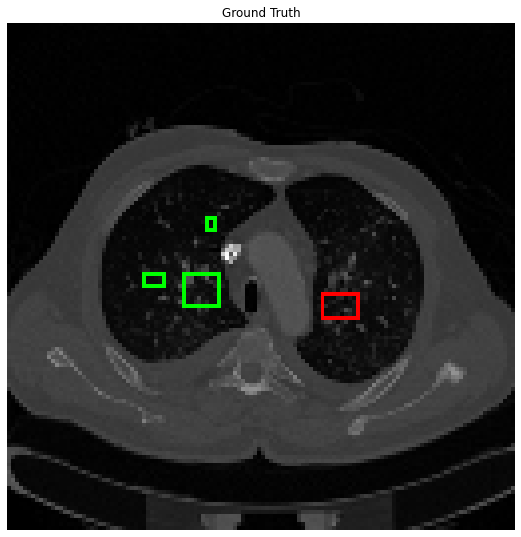

16


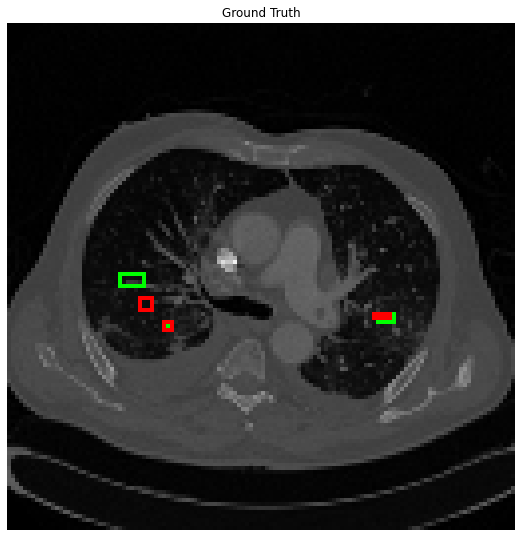

24


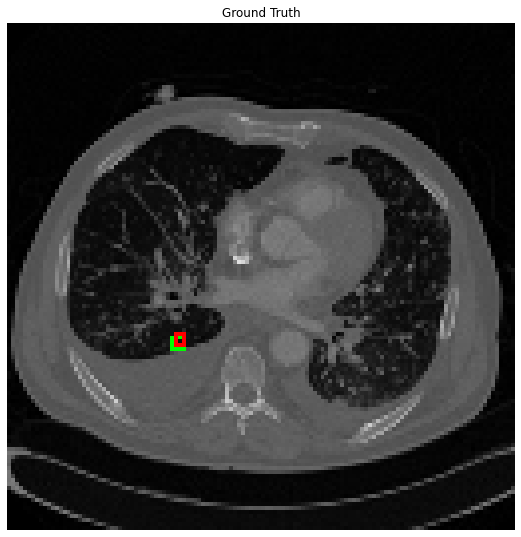

32


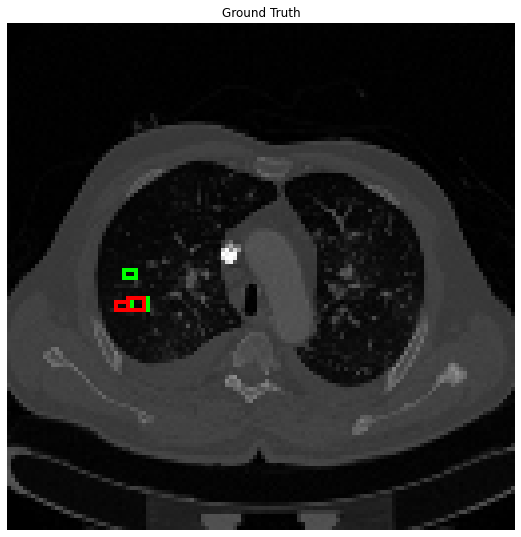

40


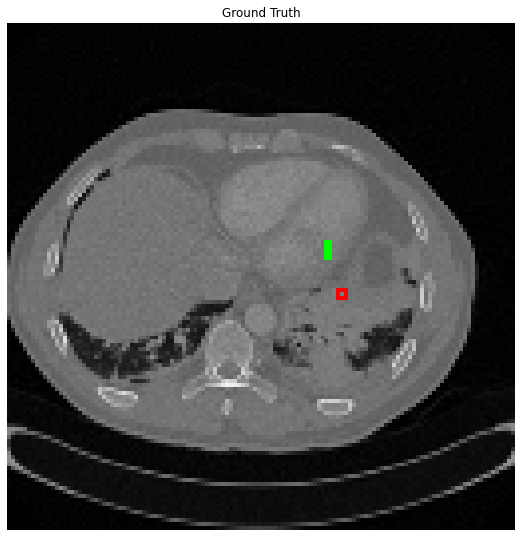

48


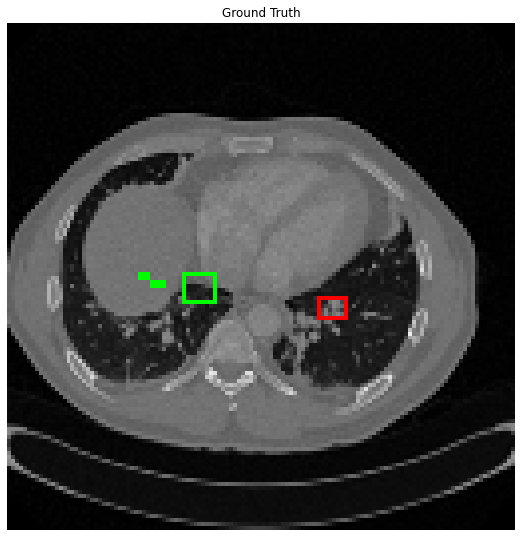

50


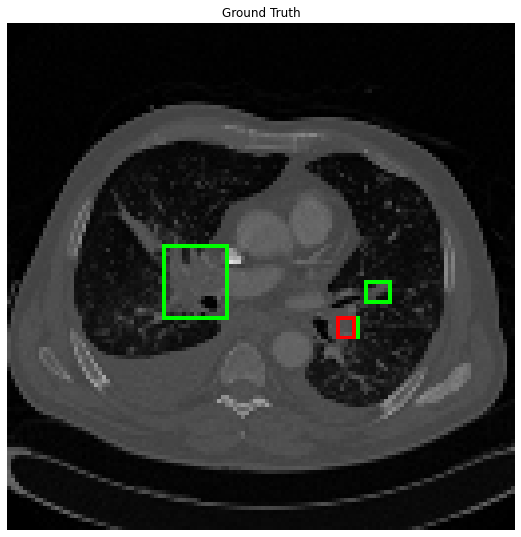

In [145]:
def test(test_loader, model, device):
    """
    Test function for evaluating the model on the test data.

    Args:
        test_loader (torch.utils.data.DataLoader): Test loader containing images
        model (torch.nn.Module): Trained model
        device (torch.device): Device on which to perform testing
        loss_fn: Loss function for calculating loss

    Returns:
        float: Average test loss
    """

    model.eval()
    with torch.no_grad():
        temp_loss = 0.0
        i = 0
        ground_truth_boxes = []
        predicted_boxes = []

        for images, labels in test_loader:
            i += 1
            imgs = list(image.to(device) for image in images)
            annotations = [{k: v.to(device) for k, v in t.items()} for t in labels]
            loss = model(imgs,annotations )
            # losses = sum(l for l in loss.values())
            # temp_loss += losses
            
            # Extract ground truth and predicted bounding box coordinates
            for annotation in annotations:
                gt_bbox = []
                for bbox in annotation["boxes"]:
                    x, y, xmax, ymax = bbox.tolist()
                    gt_bbox.append([x, y, xmax, ymax])
                ground_truth_boxes.append(gt_bbox)

            for prediction in loss:
                pred_bbox = []
                for bbox in prediction["boxes"]:
                    x, y, xmax, ymax = bbox.tolist()
                    pred_bbox.append([x, y, xmax, ymax])
                predicted_boxes.append(pred_bbox)
                
            plot_gt_pred(images, ground_truth_boxes, predicted_boxes)

        # Call the function to plot ground truth and predicted bounding boxes
        # plot_gt_pred(test_loader, ground_truth_boxes, predicted_boxes)

    # return temp_loss.item()
    return ground_truth_boxes , predicted_boxes


gt,pred = test(test_loader, model, device)